# 1. First Tutorial: Manifold Fitting and Clustering on GSE59739
The test dataset for the first tutorial contains 622 cells from the GSE59739 dataset, originating from the mouse lumbar dorsal root ganglion. We used CellScope for data normalization, the first step of manifold fitting, and the second step of manifold fitting. After fitting, we performed hierarchical clustering and visualization on the processed data.

In [1]:
import sys
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import CellScope

file_path = 'Test Data/'
data_name = 'GSE59739.mat'
data_path = file_path+data_name
Data = loadmat(data_path)
fea_raw = Data['fea_raw']

fea_raw,fea_log,fea = CellScope.cs.Normalization(fea_raw)
fea_Fitting_1, Signal_Space, Center_index = CellScope.cs.Manifold_Fitting_1(fea, num_pca = 100, num_Selected_Gene = 500, knn = 20, num_center = 0, random_seed = 83)
fea_Fitting_2, fitting_index, index_after_outlier_removal = CellScope.cs.Manifold_Fitting_2(fea_Fitting_1, num_neighbor = 5, fitting_prop = 0.05, coeff = 0.1, op_Outlier = False)
T_all_1 = CellScope.cs.GraphCluster(fea_Fitting_1, metric = None, num_cell_thre = 100000, index = [])
T_all_2 = CellScope.cs.GraphCluster(fea_Fitting_2, metric = None, num_cell_thre = 100000, index = [])
Y_1 = CellScope.cs.Visualization(fea_Fitting_1, Visualization_Method = "UMAP", random_seed = 83)
Y_2 = CellScope.cs.Visualization(fea_Fitting_2, Visualization_Method = "UMAP", random_seed = 83)

/Users/nth/opt/anaconda3/envs/fenicsproject/lib/python3.11/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/nth/opt/anaconda3/envs/fenicsproject/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/nth/opt/anaconda3/envs/fenicsproject/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for paralle

## 1.1 Highly Reliable Cliques
CellScope utilizes a highly reliable cliques discovery algorithm, capable of identifying densely populated cell clusters located at the center of a cluster.

/Users/nth/opt/anaconda3/envs/fenicsproject/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


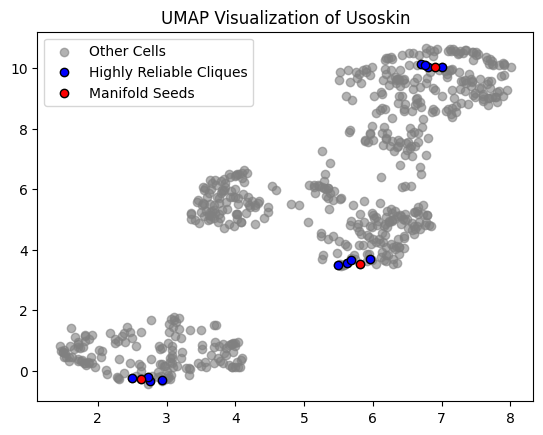

In [2]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from umap.umap_ import UMAP
import matplotlib.pyplot as plt

random_seed = 83
num_pca = 100
num_cell = fea.shape[0]
knn = 20
pca = PCA(n_components=num_pca, random_state=random_seed)
fea_pca = pca.fit_transform(fea)

nbrs = NearestNeighbors(n_neighbors=min(num_cell, 1000), algorithm='auto').fit(fea_pca)

distances, indices = nbrs.kneighbors(fea_pca)
D_NB = distances[:, :knn]
ID_NB = indices[:, :knn]
Clique = ID_NB[Center_index, 1:5].reshape(-1)
umap_model = UMAP(n_components=2, n_neighbors = 50,random_state=random_seed)
Y = umap_model.fit_transform(fea_pca)

plt.scatter(Y[:, 0], Y[:, 1], color='gray', label='Other Cells', alpha=0.6)
plt.scatter(Y[Clique, 0], Y[Clique, 1], color='blue', label='Highly Reliable Cliques', edgecolor='black')
plt.scatter(Y[Center_index, 0], Y[Center_index, 1], color='red', label='Manifold Seeds', edgecolor='black')
plt.legend()
plt.title('UMAP Visualization of Usoskin')
plt.show()

## 1.2 CellScope identified genes with greater inter-class differences.
CellScope selects genes with smaller intra-class variance and larger inter-class variance.

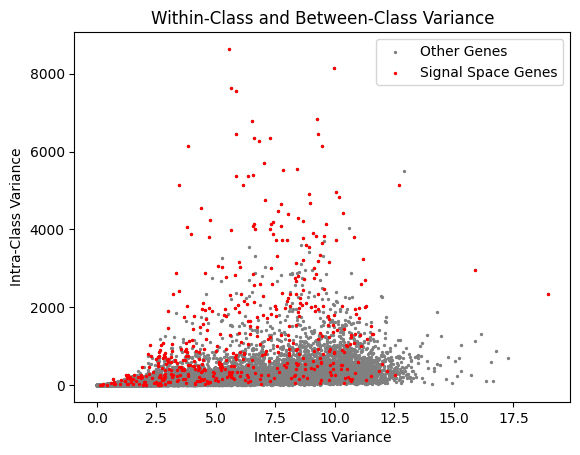

In [3]:
def compute_variances(Gene, cell_type):
    unique_classes = np.unique(cell_type)
    n_genes = Gene.shape[1]
    overall_mean = np.mean(Gene, axis=0)
    within_class_var = np.zeros(n_genes)
    between_class_var = np.zeros(n_genes)
    for cls in unique_classes:
        cls_indices = np.where(cell_type == cls)[0]
        class_mean = np.mean(Gene[cls_indices], axis=0)
        within_class_var += np.sum((Gene[cls_indices] - class_mean) ** 2, axis=0)
        between_class_var += len(cls_indices) * (class_mean - overall_mean) ** 2
    within_class_var /= Gene.shape[0]
    return within_class_var, between_class_var
cell_type = Data['label_1_numr'].reshape(-1)
within_class_var, between_class_var = compute_variances(fea_log, cell_type)
plt.scatter(within_class_var, between_class_var, color='gray', s=2, label='Other Genes')
plt.scatter(within_class_var[Signal_Space], between_class_var[Signal_Space], color='red', s=2, label='Signal Space Genes')
plt.xlabel('Inter-Class Variance')
plt.ylabel('Intra-Class Variance')
plt.title('Within-Class and Between-Class Variance')
plt.legend()
plt.show()

## 1.4 Second Step of Manifold Fitting
CellScope performs the second step of manifold fitting for cluster boundary points.

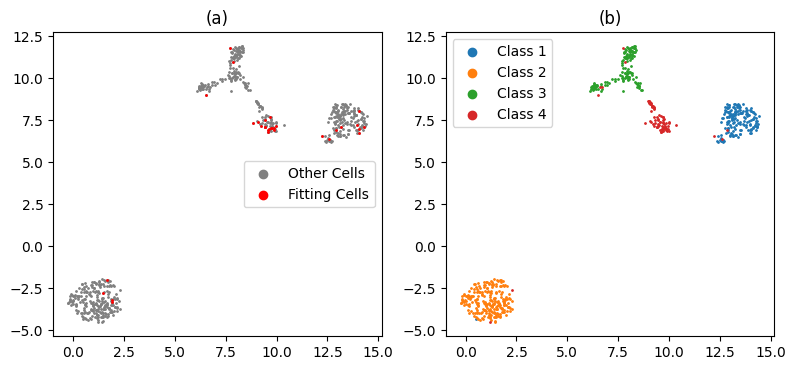

In [4]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(Y_1[:, 0], Y_1[:, 1], s=1, color='gray', label='Other Cells')
plt.scatter(Y_1[fitting_index, 0], Y_1[fitting_index, 1], s=1, color='red', label='Fitting Cells')
plt.title('(a)')
plt.legend(markerscale=6, loc='right')

plt.subplot(1, 2, 2)
unique_classes = np.unique(cell_type)
for cls in unique_classes:
    indices = np.where(cell_type == cls)
    plt.scatter(Y_1[indices, 0], Y_1[indices, 1], s=1, label=f'Class {cls}')
plt.title('(b)')
plt.legend(markerscale=6, loc='best')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 1.5 Hierarchical Clustering and Visualization Results

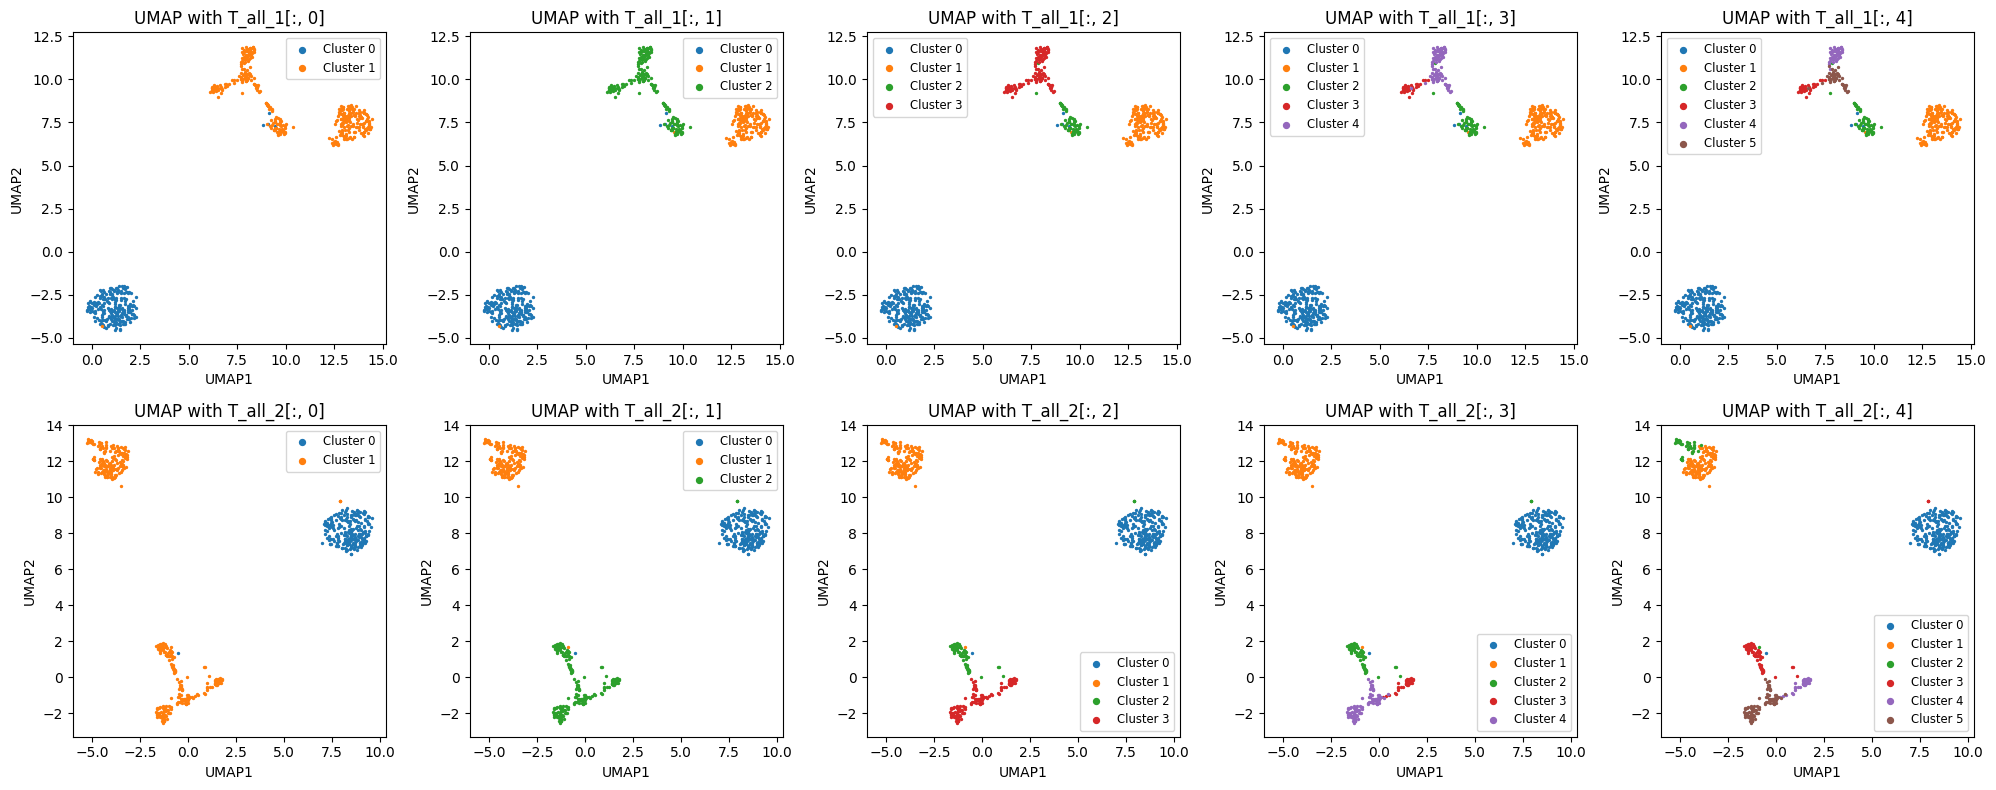

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i in range(5):
    ax = axes[0,i % 5]
    unique_labels = np.unique(T_all_1[:, i])
    for label in unique_labels:
        ax.scatter(
            Y_1[T_all_1[:, i] == label, 0], 
            Y_1[T_all_1[:, i] == label, 1], 
            label=f'Cluster {int(label)}', 
            s=2
        )

    ax.set_title(f'UMAP with T_all_1[:, {i}]')
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.legend(loc='best', fontsize='small', markerscale=3)

for i in range(5):
    ax = axes[1,i % 5]
    unique_labels = np.unique(T_all_2[:, i])
    for label in unique_labels:
        ax.scatter(
            Y_2[T_all_2[:, i] == label, 0], 
            Y_2[T_all_2[:, i] == label, 1], 
            label=f'Cluster {int(label)}', 
            s=2
        )

    ax.set_title(f'UMAP with T_all_2[:, {i}]')
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.legend(loc='best', fontsize='small', markerscale=3)

plt.tight_layout()
plt.show()

## 1.6 Comparison of Visualization Results
Compared to the data without manifold fitting, the visualization results exhibit a clearer cluster structure.

/Users/nth/opt/anaconda3/envs/fenicsproject/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


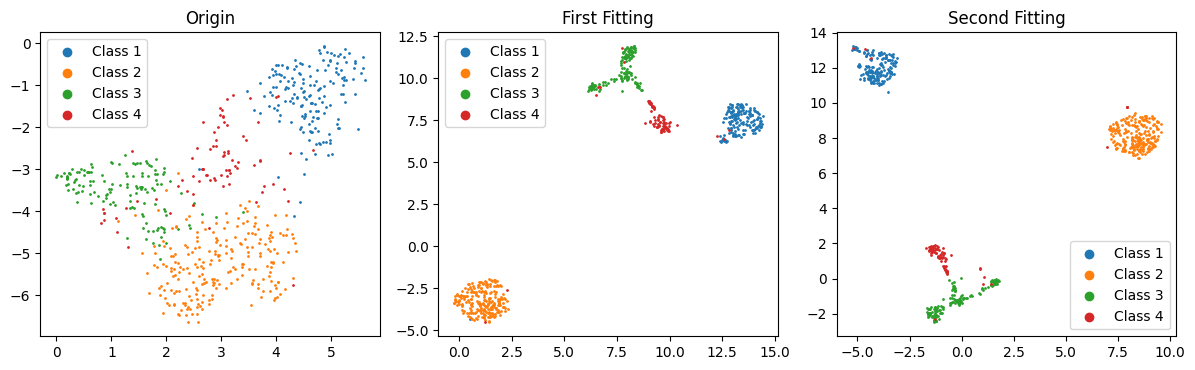

In [6]:
plt.figure(figsize=(12, 4))
umap_model = UMAP(n_components=2, n_neighbors = 15,random_state=random_seed)
Y = umap_model.fit_transform(fea)
plt.subplot(1, 3, 1)
unique_classes = np.unique(cell_type)
for cls in unique_classes:
    indices = np.where(cell_type == cls)
    plt.scatter(Y[indices, 0], Y[indices, 1], s=1, label=f'Class {cls}')
plt.title('Origin')
plt.legend(markerscale=6, loc='best')

plt.subplot(1, 3, 2)
unique_classes = np.unique(cell_type)
for cls in unique_classes:
    indices = np.where(cell_type == cls)
    plt.scatter(Y_1[indices, 0], Y_1[indices, 1], s=1, label=f'Class {cls}')
plt.title('First Fitting')
plt.legend(markerscale=6, loc='best')

plt.subplot(1, 3, 3)
unique_classes = np.unique(cell_type)
for cls in unique_classes:
    indices = np.where(cell_type == cls)
    plt.scatter(Y_2[indices, 0], Y_2[indices, 1], s=1, label=f'Class {cls}')
plt.title('Second Fitting')
plt.legend(markerscale=6, loc='best')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 1.7 Clustering Accuracy Calculation
If the golden label are known, CellScope provides calculations for various clustering accuracy metrics.

In [7]:
pred_label = T_all_1[:,3].reshape(-1)
true_label = Data['label_1_numr'].reshape(-1)
metric_results = CellScope.cm.calculate_metrics(true_label,pred_label)
print("Clustering Metrics Results:")
print("-" * 30)
for metric, score in metric_results.items():
    print(f"{metric: <20}: {score:.2f}")
print("-" * 30)

Clustering Metrics Results:
------------------------------
Accuracy            : 0.92
NMI                 : 0.88
ARI                 : 0.90
F1 Score            : 0.94
Jaccard             : 0.85
------------------------------


# 2 Second Tutorials: Tree Structure Visualization and Gene Analysis on Siletti-1
In the Second Tutorial, the dataset consists of 4,714 cells from the human midbrain red nucleus region, sourced from CELLXGENE. We provide the data download method here.

In [8]:
import requests
import anndata
import CellScope
import os
url = "https://datasets.cellxgene.cziscience.com/5488ff72-58ed-4f0d-913c-1b6d4d8412b1.h5ad"
file_path = os.path.join("Test Data/", "Siletti-1.h5ad")
response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(file_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
adata = anndata.read_h5ad("Test Data/Siletti-1.h5ad")
fea_raw = adata.X
cell_types = adata.obs['cell_type']
label = np.array(cell_types)

## 2.1 CellScope on Siletti-1

In [9]:
from scipy.sparse import issparse
fea_raw,fea_log,fea = CellScope.cs.Normalization(fea_raw)
fea_Fitting_1, Signal_Space, Center_index = CellScope.cs.Manifold_Fitting_1(fea)
if issparse(fea_Fitting_1):
    fea_Fitting_1 = fea_Fitting_1.toarray()
fea_Fitting_2, fitting_index, index_after_outlier_removal = CellScope.cs.Manifold_Fitting_2(fea_Fitting_1)
T_all_1 = CellScope.cs.GraphCluster(fea_Fitting_1)
T_all_2 = CellScope.cs.GraphCluster(fea_Fitting_2)
Y_Fitting_1 = CellScope.cs.Visualization(fea_Fitting_1)
Y_Fitting_2 = CellScope.cs.Visualization(fea_Fitting_2)

/Users/nth/opt/anaconda3/envs/fenicsproject/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/nth/opt/anaconda3/envs/fenicsproject/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


## 2.2 Tree Structure Visualization
CellScope can generate visualization results for the cells in each node of the tree structured visualization and save the results in the Res folder.

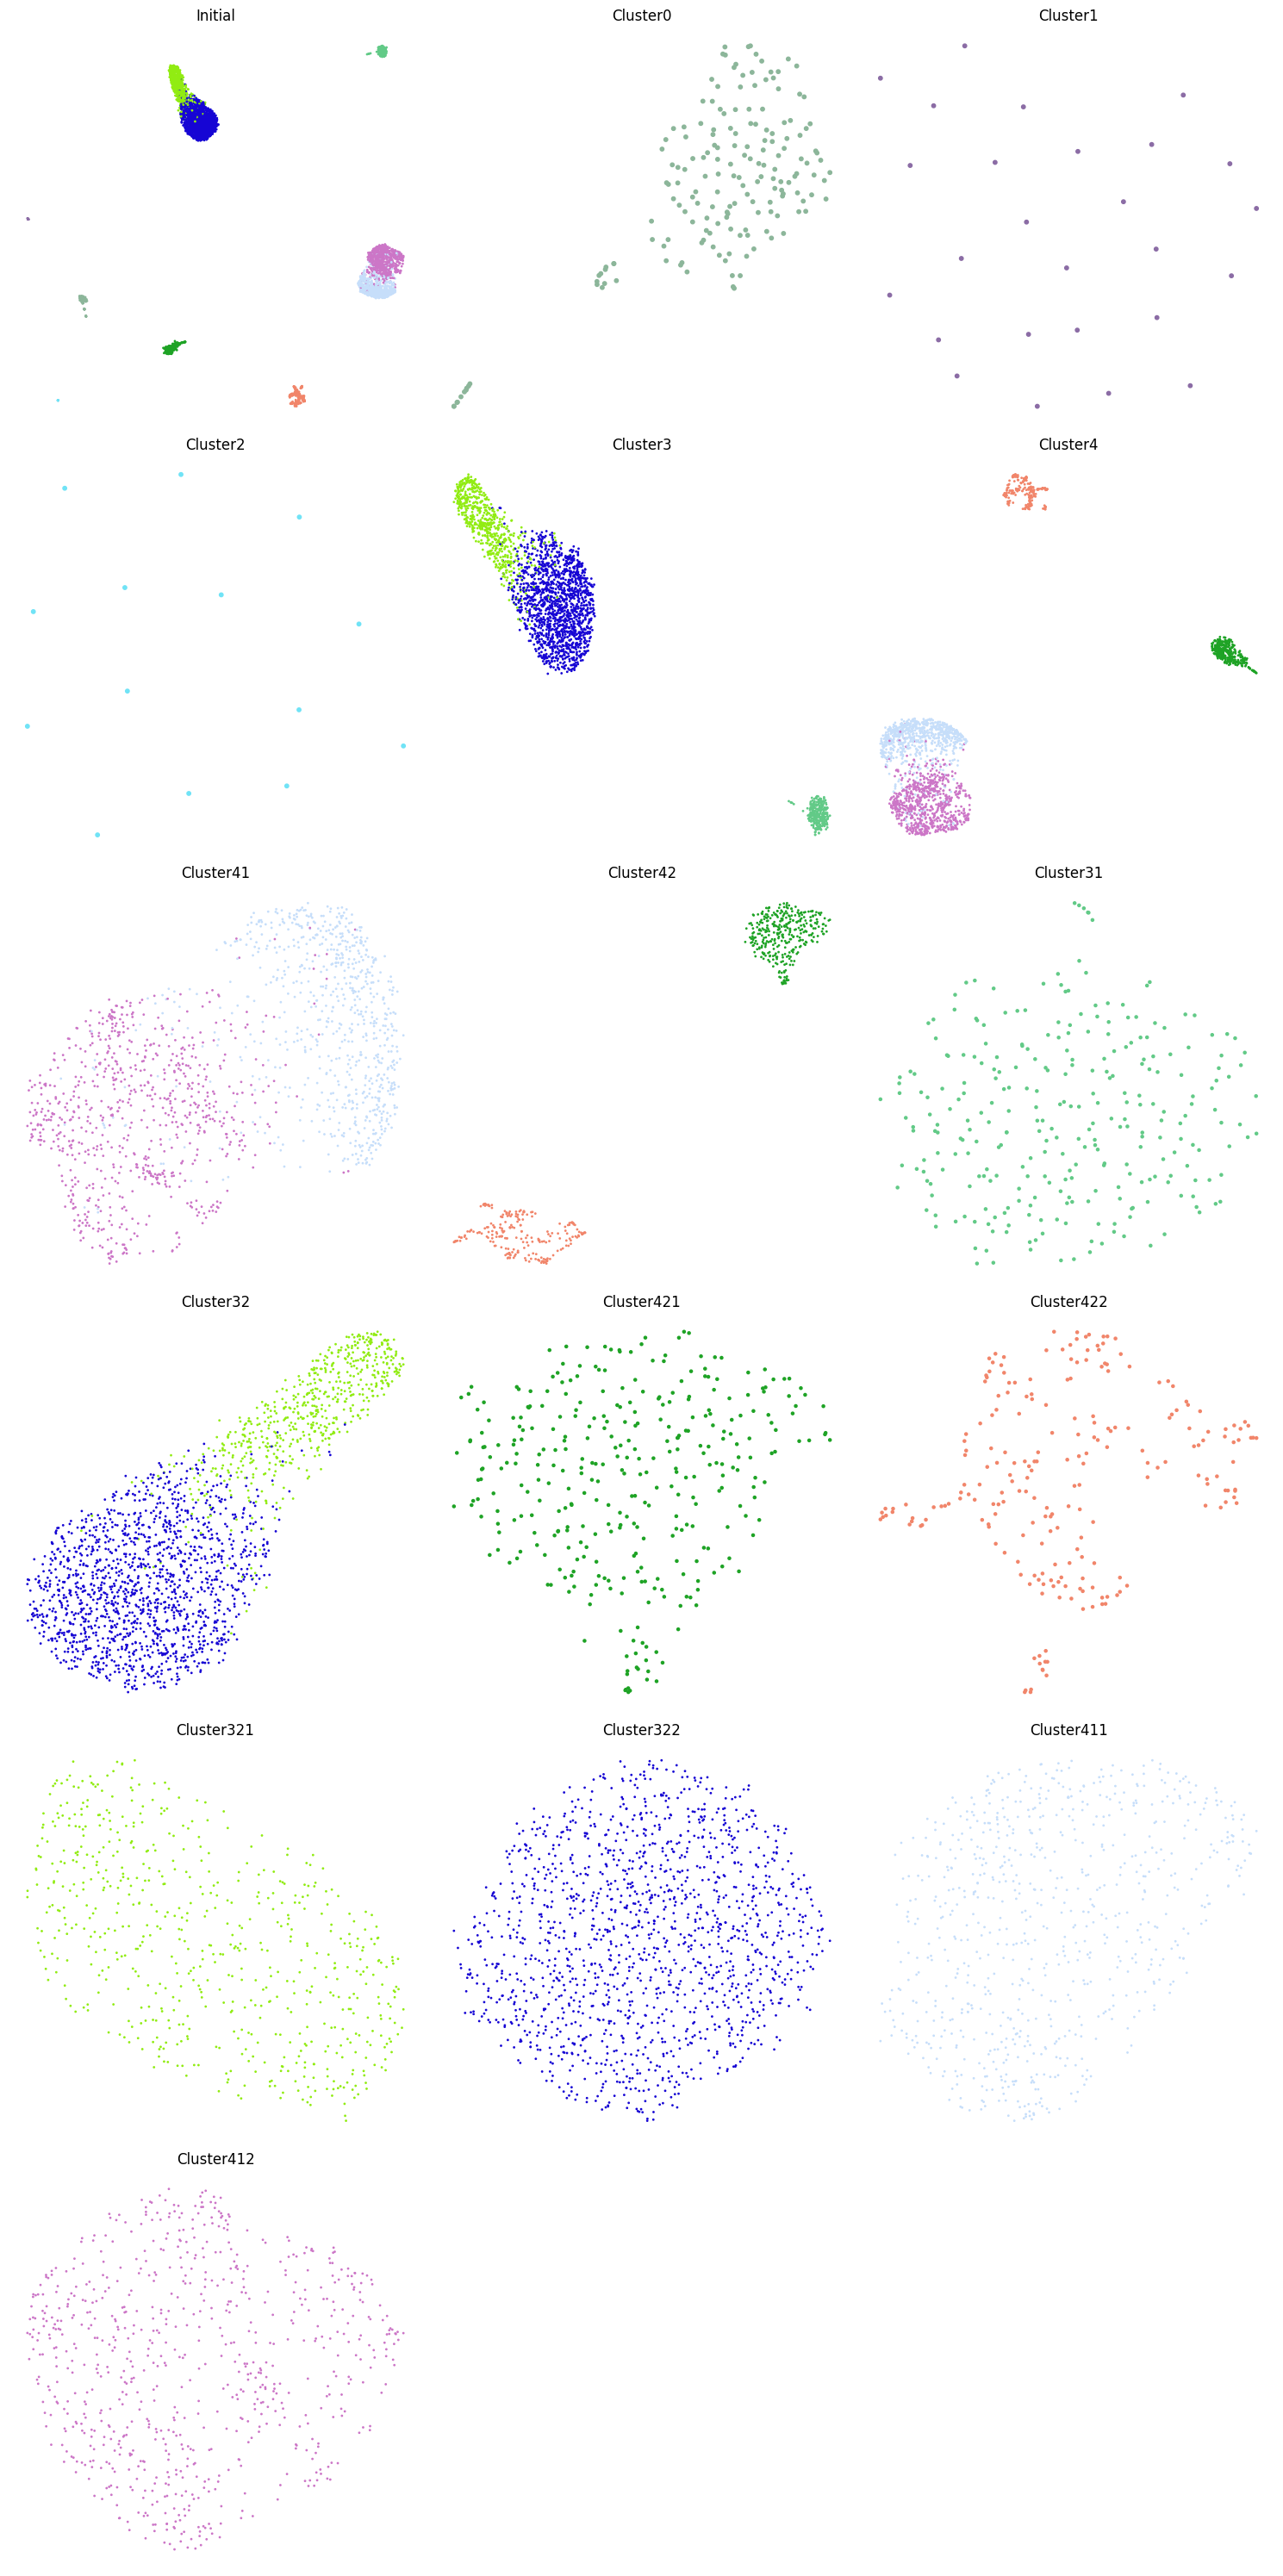

In [10]:
Y_initial, label_step0, Y_1, Title_1, Y_all, Title_all, index_1, index_all, step0, step1 = CellScope.ts.generate_tree_structured(fea_Fitting_1, T_all_1, step0 = None, step1 = 8)
CellScope.ts.visualize_tree_structured(Y_initial, label_step0, Y_1, Title_1, Y_all, Title_all, index_1, index_all, step0, step1, T_all_1, save_fig = True, save_path='Res')

## 2.3 Visualization on Marker Gene
CellScope supports various methods for comparing marker gene expression, including violin plots, heatmaps, etc.

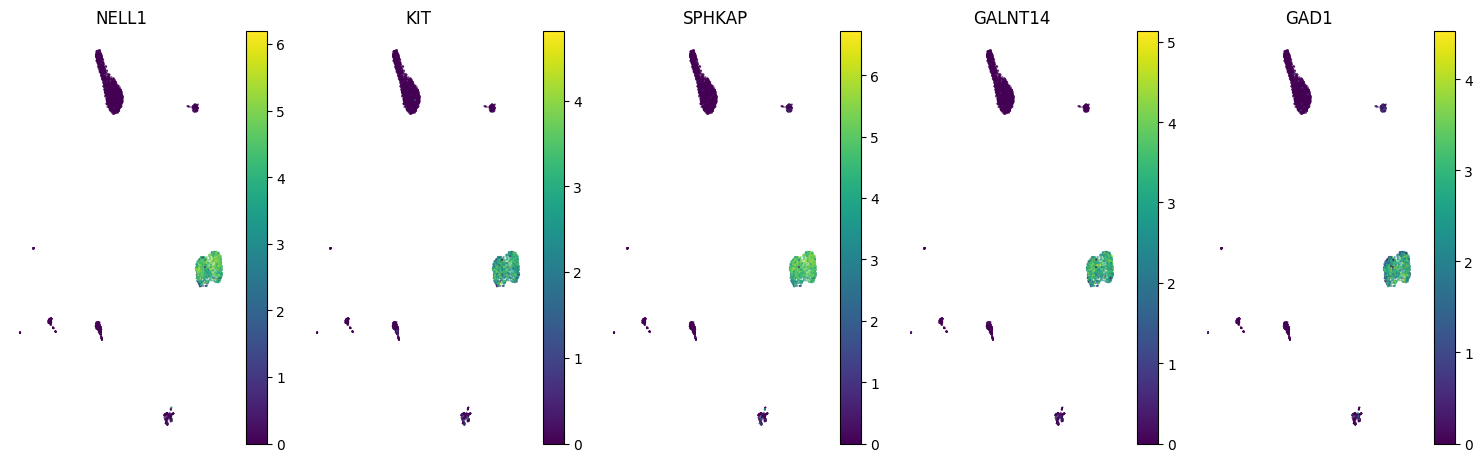

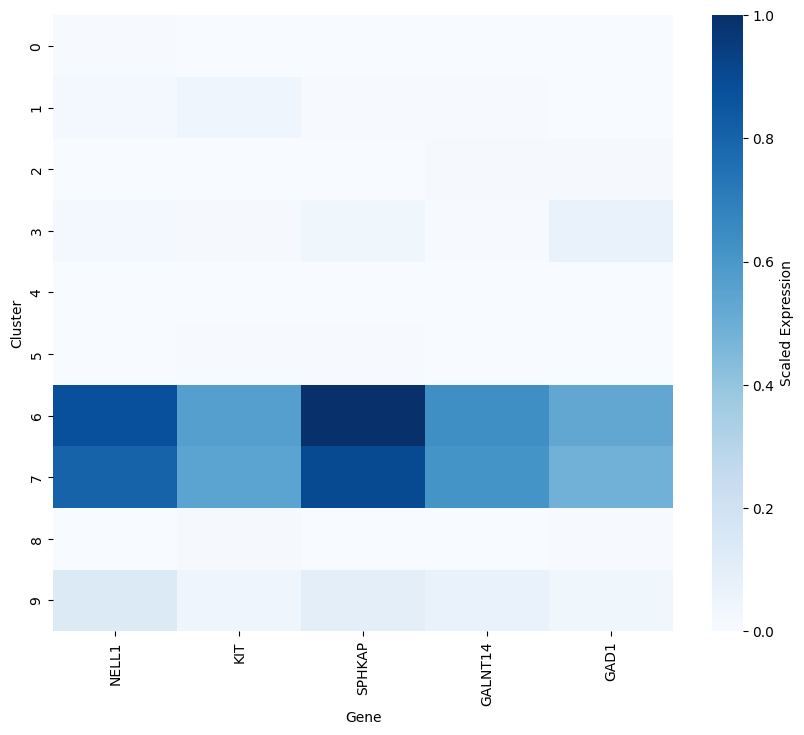

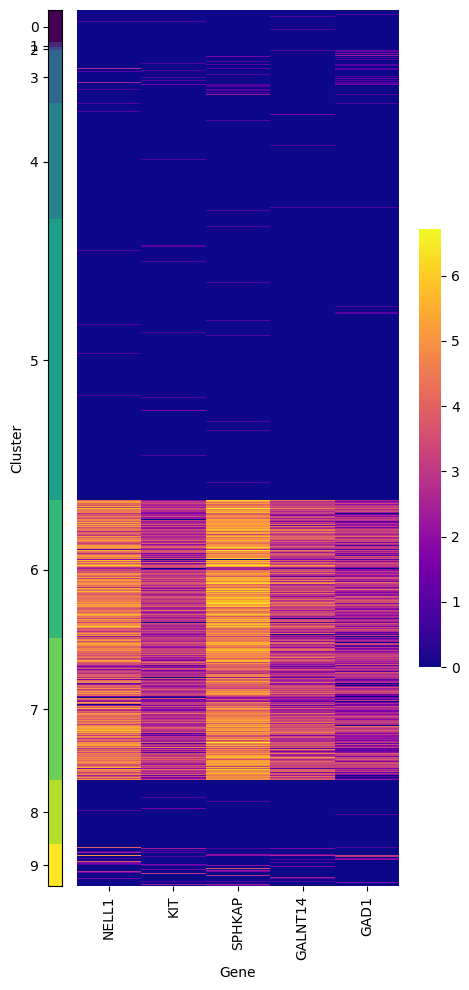

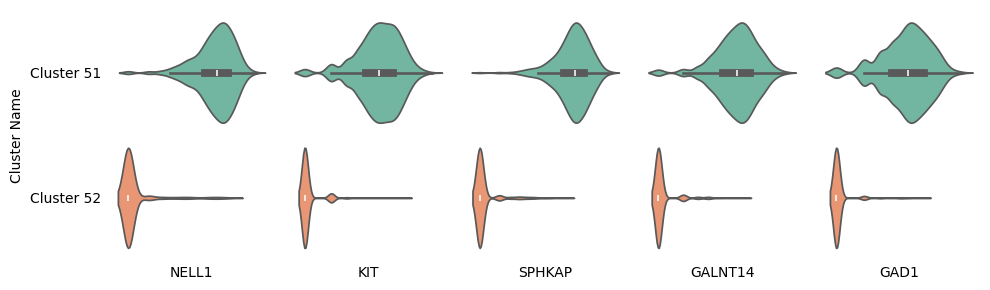

In [13]:
cluster1 = index_all[0]
cluster2 = index_all[1]
label = T_all_1[:,8]
Gene_Name = adata.var['feature_name']
marker_gene_indices,_ = CellScope.fm.FindMarker(fea_log, cluster1, cluster2, selected_number = 5, selected_method = 'diff pct')
marker_gene_name = Gene_Name[marker_gene_indices]
CellScope.gev.scatter_gene_expression(fea_log,Y_Fitting_1,marker_gene_indices,marker_gene_name,figsize=(15, 9), subplot_size = None, 
                            save_fig=False)
CellScope.gev.plot_mean_expression_heatmap(fea_log, marker_gene_indices,marker_gene_name, label,
                                           save_fig=False)
CellScope.gev.plot_clustered_heatmap(fea_log, marker_gene_indices, marker_gene_name, 
                           label, save_fig=False)
CellScope.gev.compare_violin_plot_between_classes(fea_log, marker_gene_indices, marker_gene_name, 
                                        cluster1, cluster2, class_name=['Cluster 51', 'Cluster 52'], 
                                        figsize=(10, 3), save_fig=False)

## 2.4 Gene Analysis
CellScope provides a hierarchical identity for each gene, indicating its different roles at varying resolutions.

In [12]:
layer = [index_1[1],np.setdiff1d(range(T_all_1.shape[0]),index_1[1]),index_all[0],index_all[1],index_all[2],index_all[3]]
fea_log_array = fea_log.toarray()
Res, label, label_str, flow_labels = CellScope.ga.Gene_Analysis(fea_log_array,layer)
CellScope.ga.plot_sankey(label_str,save_fig=True, save_path='Res/sankey_diagram.pdf')

Figure saved to Res/sankey_diagram.pdf


,Layer 1,Layer 2,Layer 3
Housekeeper Gene,57952,57422,58480
Type-Related Gene,900,1193,435
Type-Determining Gene,384,621,321
